# Improve your images

First make sure you select **GPU** as runtime type under Runtime > Runtime Type

In [1]:
!pip install --force tqdm==4.24.0

     |████████████████████████████████| 51kB 1.9MB/s 
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.24.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Using Google Drive

Google Colab does not store data after you close the session.
We will be using Google Drive to permanently store created images and latent vectors.

If you don't want to use Google Drive you can skip this step, just make sure you download the results you want to keep then.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


## Getting started

Alright, now that the annoying part is done. Let's get started!

First we need to clone the Repo and open the directory.

In [5]:
!git clone https://github.com/ju-leon/RetouchML.git

Cloning into 'RetouchML'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 207 (delta 16), reused 20 (delta 6), pack-reused 168
Receiving objects: 100% (207/207), 39.82 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [3]:
%cd RetouchML/
!mkdir aligned_images raw_images alignement_vector out
%ls

/content/drive/My Drive/RetouchML
mkdir: cannot create directory ‘aligned_images’: File exists
mkdir: cannot create directory ‘raw_images’: File exists
mkdir: cannot create directory ‘alignement_vector’: File exists
mkdir: cannot create directory ‘out’: File exists
 adaptive.py          encoder/                  __pycache__/
 aligned_images/      ffhq_dataset/             raw_images/
 alignement_vector/   fit_faces.py              README.md
 align_images.py      generated_images/         robust_loss/
 Beautify.ipynb       latent_representations/   run_generator.py
 cache/               LICENSE.txt               run_metrics.py
 data/                masks/                    run_projector.py
 dataset_tool.py      metrics/                  run_training.py
 dnnlib/              out/                      swa.py
 Dockerfile          'Predict Beauty.ipynb'     test_nvcc.cu
 docs/                pretrained_networks.py    training/
 encode_images.py     projector.py              videos/


In [6]:
import glob, os
import PIL.Image

## Upload your image

To use your own iamge, upload it into the raw_iamges folder. then hit run so see if its there...

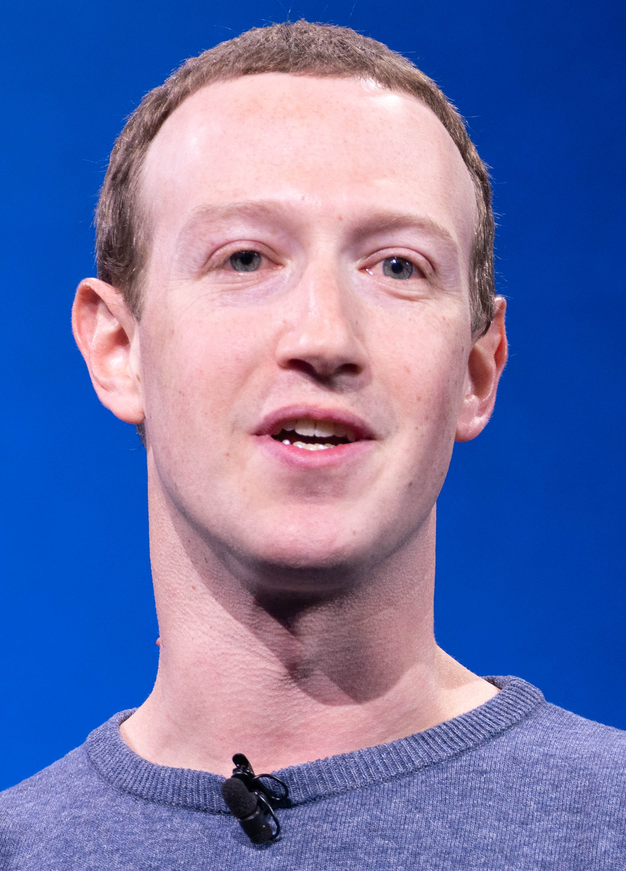

In [7]:
path = "raw_images/"
valid_images = (".jpg",".png")
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((int(img.size[0]/3), int(img.size[1]/3)), PIL.Image.LANCZOS))


## Aligning images

All there?
Then let's go ahead and crop on the head.
Run the following skripts to crop and see the results.

In [14]:
!python align_images.py raw_images/ aligned_images/ alignement_vector/

Using TensorFlow backend.
64045056/64040097 [==============================] - 21s 0us/step


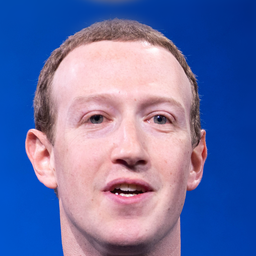

In [15]:
path = "aligned_images/"
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((256,256), PIL.Image.LANCZOS))

## Encoding

Now comes the fun part. We need to translate what we can see into a latent vector.
for that we will use a StyleGan encoder.

This will take a while, so sit back and let Googles GPU do their jobs...

In [16]:
!python encode_images.py --help

Using TensorFlow backend.
usage: encode_images.py [-h] [--data_dir DATA_DIR] [--mask_dir MASK_DIR]
                        [--load_last LOAD_LAST] [--dlatent_avg DLATENT_AVG]
                        [--model_url MODEL_URL] [--model_res MODEL_RES]
                        [--batch_size BATCH_SIZE] [--optimizer OPTIMIZER]
                        [--vgg_url VGG_URL] [--image_size IMAGE_SIZE]
                        [--resnet_image_size RESNET_IMAGE_SIZE] [--lr LR]
                        [--decay_rate DECAY_RATE] [--iterations ITERATIONS]
                        [--decay_steps DECAY_STEPS]
                        [--early_stopping [EARLY_STOPPING]]
                        [--early_stopping_threshold EARLY_STOPPING_THRESHOLD]
                        [--early_stopping_patience EARLY_STOPPING_PATIENCE]
                        [--load_effnet LOAD_EFFNET]
                        [--load_resnet LOAD_RESNET]
                        [--use_preprocess_input [USE_PREPROCESS_INPUT]]
                 

In [17]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/ \
    --vgg_url=https://rolux.org/media/stylegan/vgg16_zhang_perceptual.pkl \
    --lr=0.25 --iterations=750 --use_l1_penalty=0.5

Using TensorFlow backend.
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
58892288/58889256 [==============================] - 1s 0us/step
  0% 0/1 [00:00<?, ?it/s]Rects:
rectangles[[(46, 81) (201, 236)]]
Saving mask masks/zuckerberg_01.png
Loading mask masks/zuckerberg_01.png

  0% 0/750 [00:00<?, ?it/s]
zuckerberg_01: loss 310.6978; lr 0.2500:   0% 0/750 [00:17<?, ?it/s]
zuckerberg_01: loss 310.6978; lr 0.2500:   0% 1/750 [00:18<3:46:19, 18.13s/it]
zuckerberg_01: loss 291.3265; lr 0.2500:   0% 1/750 [00:19<3:59:56, 19.22s/it]
zuckerberg_01: loss 291.3265; lr 0.2500:   0% 2/750 [00:19<1:59:49,  9.61s/it]
zuckerberg_01: loss 272.2776; lr 0.2500:   0% 2/750 [00:20<2:06:45, 10.17s/it]
zuckerberg_01: loss 272.2776; lr 0.2500:   0% 3/750 [00:20<1:24:24,  6.78s/it]
zuckerberg_01: loss 249.6948; lr 0.2500:   0% 3/750 [00:21<1:29:00,  7.15s/it]
zuckerbe

### Result

And here we go. The following image is the encoded image in latent sapce. It should look pretty similar to the original representation, although it might vary slightly.


If you're not happy with the result try running the encoding again with different parameters.

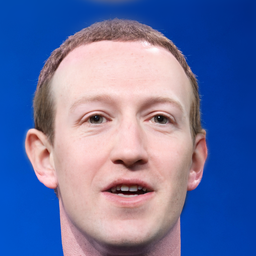

In [19]:
path = "generated_images/"
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((256,256), PIL.Image.LANCZOS))

In [11]:
import keras
model = keras.models.load_model('/content/drive/My Drive/Data/SCUT/beauty_pred2.ker')

In [9]:
import math
import pickle
import PIL.Image
import numpy as np
#import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator
URL_FFHQ = 'http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir="cache") as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

model_res = 1024
model_scale = int(2*(math.log(model_res,2)-1))

def generate_raw_image(latent_vector):
    latent_vector = latent_vector.reshape((1, model_scale, 512))
    generator.set_dlatents(latent_vector)
    return generator.generate_images()[0]

def generate_image(latent_vector):
    img_array = generate_raw_image(latent_vector)
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


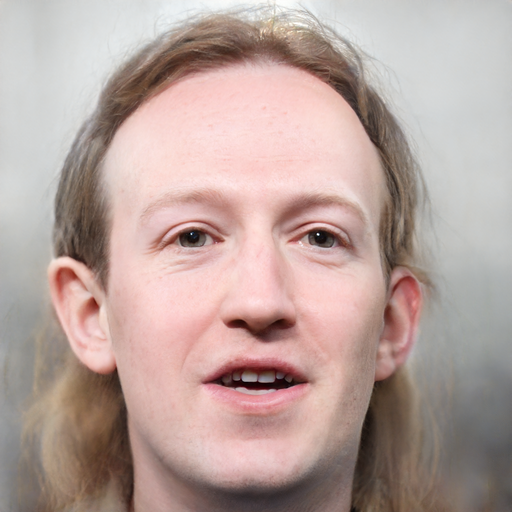

 - x:0, k:0
 - x:0, k:1
 - x:0, k:2
 - x:0, k:3
 - x:0, k:4
 - x:0, k:5
 - x:0, k:6
 - x:0, k:7
 - x:0, k:8
 - x:0, k:9
 - x:0, k:10
 - x:0, k:11
 - x:0, k:12
 - x:0, k:13
 - x:0, k:14
 - x:0, k:15
 - x:0, k:16
 - x:0, k:17
 - x:0, k:18
 - x:0, k:19
 - x:0, k:20
 - x:0, k:21
 - x:0, k:22
 - x:0, k:23
 - x:0, k:24
 - x:0, k:25
 - x:0, k:26
 - x:0, k:27
 - x:0, k:28
 - x:0, k:29
 - x:0, k:30
 - x:0, k:31
 - x:0, k:32
 - x:0, k:33
 - x:0, k:34
 - x:0, k:35
 - x:0, k:36
 - x:0, k:37
 - x:0, k:38
 - x:0, k:39
 - x:0, k:40
 - x:0, k:41
 - x:0, k:42
 - x:0, k:43
 - x:0, k:44
 - x:0, k:45
 - x:0, k:46
 - x:0, k:47
 - x:0, k:48
 - x:0, k:49
 - x:0, k:50
 - x:0, k:51
 - x:0, k:52
 - x:0, k:53
 - x:0, k:54
 - x:0, k:55
 - x:0, k:56
 - x:0, k:57
 - x:0, k:58
 - x:0, k:59
 - x:0, k:60
 - x:0, k:61
 - x:0, k:62
 - x:0, k:63
 - x:0, k:64
 - x:0, k:65
 - x:0, k:66
 - x:0, k:67
 - x:0, k:68
 - x:0, k:69
 - x:0, k:70
 - x:0, k:71
 - x:0, k:72
 - x:0, k:73
 - x:0, k:74
 - x:0, k:75
 - x:0, k:76
 - x:0, k

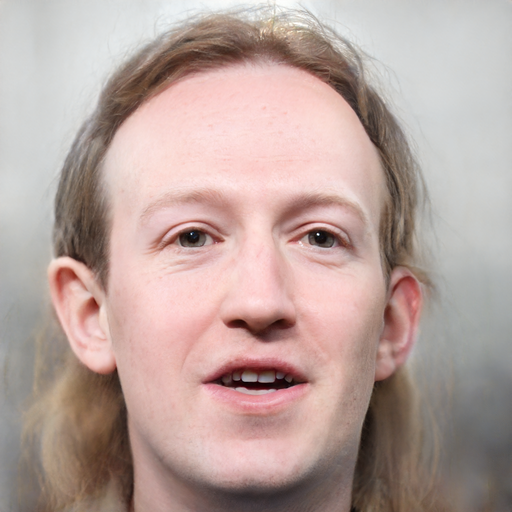

In [12]:
import copy

latent_vector = np.load('latent_representations/zuckerberg_01.npy')
#s2 = np.load('latent_representations/1024px-Donald_Trump_official_portrait_01.npy')
#/content/RetouchML/latent_representations/1024px-Donald_Trump_official_portrait_01.npy
img = generate_image(1 * latent_vector)
display(img.resize((512,512),PIL.Image.LANCZOS))

initial_predition = model.predict(np.array(img.resize((128,128),PIL.Image.LANCZOS)).reshape(1,128,128,3))[0][0]
gradient = np.zeros(latent_vector.shape)

prediction_images = []
for x in range(1):  
  for k in range(512):
    print(" - x:" + str(x) + ", k:" + str(k))
    direction_vector = copy.deepcopy(latent_vector)
    direction_vector[x][k] = 1
    gen_img = generate_image(direction_vector)
    prediction_images.append(np.array(gen_img.resize((128,128),PIL.Image.LANCZOS)))

#    adjusted_prediction = self.model.predict(np.array(gen_img.resize((128,128),PIL.Image.LANCZOS)).reshape(1,128,128,3))[0][0]
#    gradient[x][k] = self.initial_predition - adjusted_prediction

prediction_images = np.array(prediction_images)
predictions = model.predict(prediction_images.reshape(-1,128,128,3))

img = generate_image(latent_vector + gradient)
display(img.resize((512,512),PIL.Image.LANCZOS))
img.save("generated_images/IMG_8918_01.png", "PNG")

In [13]:
for k in range(18):
  gradient[k] = (predictions - initial_predition).reshape(512)
  
print(gradient)

[[ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]
 [ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]
 [ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]
 ...
 [ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]
 [ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]
 [ 0.01374334 -0.00717694 -0.00083905 ...  0.00904614 -0.00728476
  -0.01234734]]


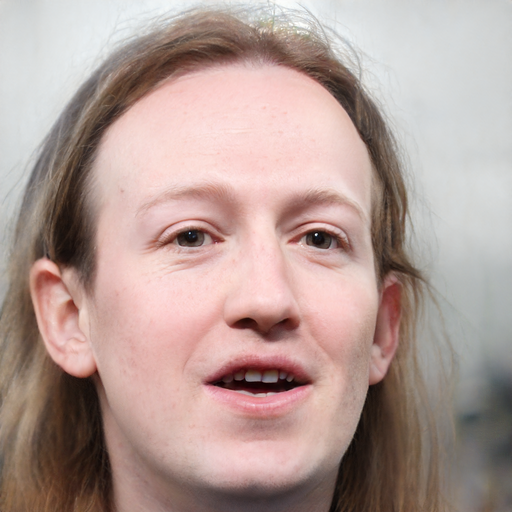

In [20]:
img = generate_image(latent_vector - 4*gradient)
display(img.resize((512,512),PIL.Image.LANCZOS))
img.save("generated_images/zuckerberg_01.png", "PNG")

In [27]:
#/content/RetouchML/masks/IMG_20200209_150540_01.png
img_name = "zuckerberg.jpg"
raw_path = "raw_images/" + img_name
out_path = "out/" + img_name
face_path = "generated_images/" 
mask_path = "masks/"
vector_path = "alignement_vector/"
!python fit_faces.py $raw_path $face_path $mask_path $vector_path $out_path


Using TensorFlow backend.
Done!


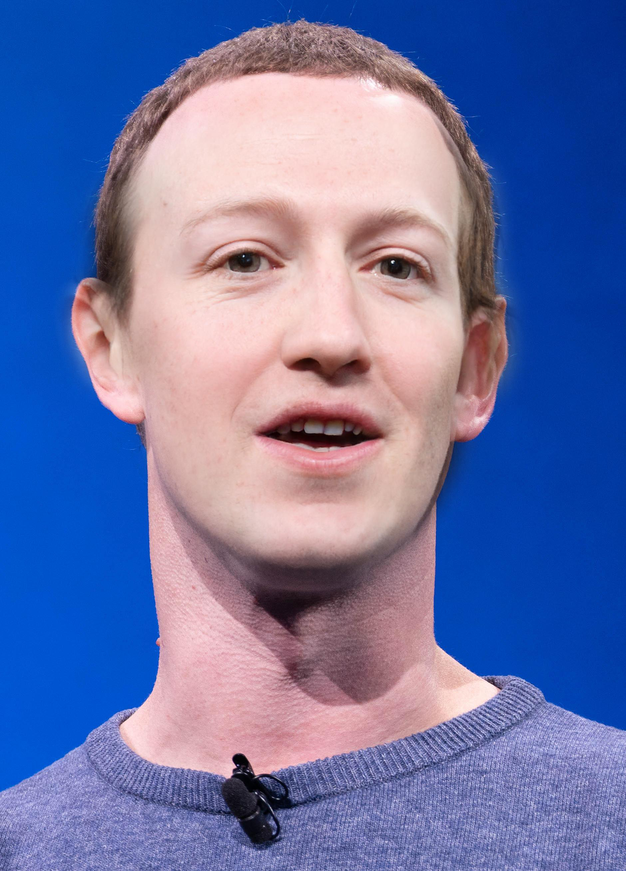

In [28]:
path = "out/"
valid_images = (".jpg",".png")
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((int(img.size[0]/3), int(img.size[1]/3)), PIL.Image.LANCZOS))
